In [1]:
import math
import numpy as np
import pandas as pd
from typing import Tuple
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def get_spot_price(token0_amount: float, token1_amount: float) -> float:
    return token1_amount / token0_amount

def get_tick_index(price: float) -> float:
    """ i = floor(log_1.0001(p)) """
    return math.floor(math.log(price, 1.0001))

In [3]:
"""
    UniswapV3 Virtual Reserves/Balances
    
    x_v = x + L / p_b ** 0.5
    y_v = y + L * p_a ** 0.5

    L: Liquidity parameter
    x: Real balance of token0
    y: Real balance of token1
    x_v: Virtual reserves of token0
    y_v: Virtual reserves of token1
    p_a: Concentrated liquidity range lower price of token x in terms of y
    p_b: Concentrated liquidity range upper price of token x in terms of y

    x_v = L / p ** 0.5
    y_v = L * p ** 0.5

    p: Price
"""

def _bound_price(p_a: float, p_b: float, p: float) -> float:
    return min(max(p, p_a), p_b)

def get_token0_real_balance(L: float, p_a: float, p_b: float, p: float) -> float:
    return L / _bound_price(p_a, p_b, p) ** 0.5 - L / p_b ** 0.5

def get_token1_real_balance(L: float, p_a: float, p_b: float, p: float) -> float:
    return L * _bound_price(p_a, p_b, p) ** 0.5 - L * p_a ** 0.5

In [4]:
"""
    UniSwapV3 Position Value

    V = x_p * p + y_p

    p: Price of x in terms of y
    x_p: Real balance of token x at price p
    y_p: Real balance of token y at price p
    V: Value of position interms of token y
"""

def get_position_value(L: float, p_a: float, p_b: float, p: float) -> float:
    x_p = get_token0_real_balance(L, p_a, p_b, p)
    y_p = get_token1_real_balance(L, p_a, p_b, p)
    return x_p * p + y_p

In [5]:
"""
    Setting up a UniSwapV3 Position
"""

def get_liquidity_parameter(p_a: float, p_b: float, p: float, position_value: float) -> float:
    p = _bound_price(p_a, p_b, p)
    return position_value / (2 * p ** 0.5 - p / p_b ** 0.5 - p_a ** 0.5)

def get_token_distrubution_given_position_value(p_a: float, p_b: float, p: float, position_value: float) -> Tuple[float, float]:
    """supply range [p_a, p_b] and intended position_value at current price"""
    L = get_liquidity_parameter(p_a, p_b, p, position_value)
    x_0 = L * (1 / p ** 0.5 - 1 / p_b ** 0.5)
    y_0 = L * (p ** 0.5 - p_a ** 0.5)
    return L, x_0, y_0

def get_token_0_given_token_1(p_a: float, p_b: float, p: float, y_0: float) -> float:
    L = y_0 / (p ** 0.5 - p_a ** 0.5)
    x_0 = L * (1 / p ** 0.5 - 1 / p_b ** 0.5)
    return x_0
    
def get_token_1_given_token_0(p_a: float, p_b: float, p: float, x_0: float) -> float:
    L = x_0 / (1 / p ** 0.5 - 1 / p_b ** 0.5)
    y_0 = L * (p ** 0.5 - p_a ** 0.5)
    return y_0

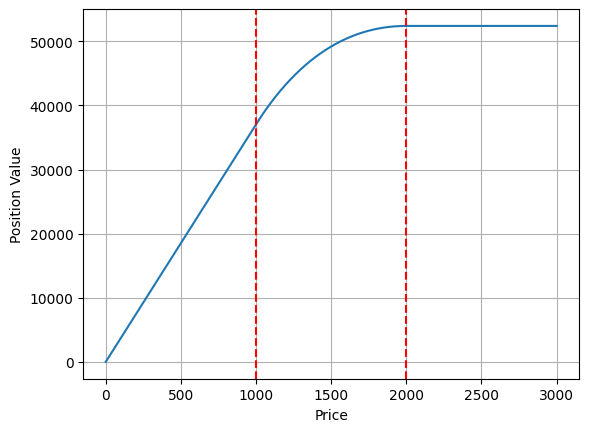

In [6]:
"""
    Consider the following UniswapV3 ETH/USDC position:
    
    L = 4000
    p_a, p_b = 1000, 2000
"""

L = 4000
p_a, p_b = 1000, 2000
V = np.vectorize(partial(get_position_value, L, p_a, p_b))

prices = np.linspace(0, 3000, 10000)
position_values = V(prices)

plt.plot(prices, position_values)
plt.axvline(x=p_a, color='r', linestyle='--')
plt.axvline(x=p_b, color='r', linestyle='--')
plt.xlabel('Price')
plt.ylabel('Position Value')
plt.grid(True)
plt.show()

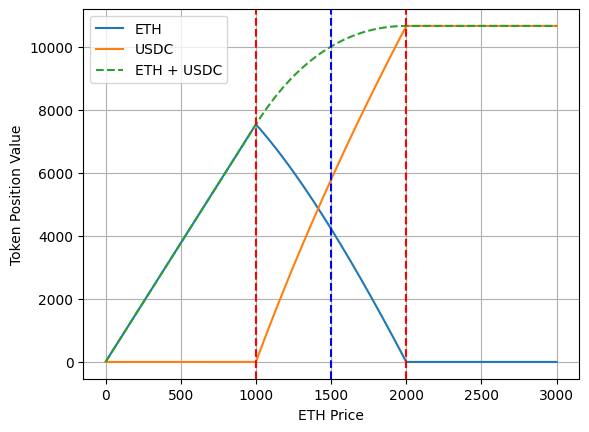

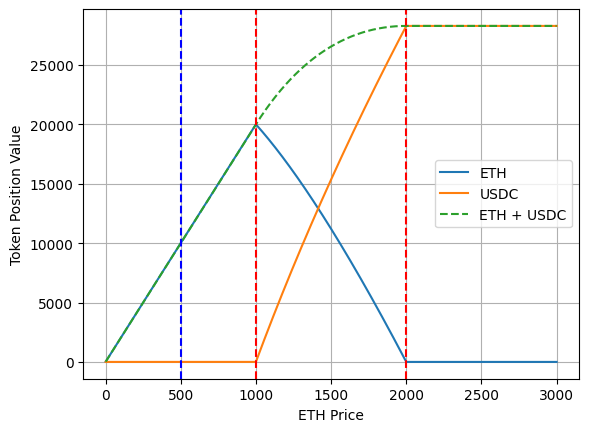

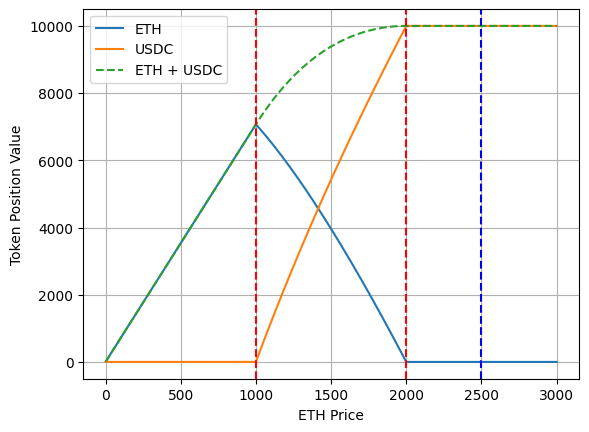

In [7]:
"""
    Consider the following UniswapV3 ETH/USDC position:

    V_0 = 10000
    p_a, p_b = 1000, 2000

    Case 1: p_0 = 1500 (p_a <= p_0 <= p_b)
    Case 2: p_0 = 500 (p_0 <= p_a)
    Case 3: p_0 = 2500 (p_0 >= p_b)
"""

def plot_token_balances(p_a: float, p_b: float, p_0: float, position_value: float=10000):
    if p_0 < p_a:
        x_0 = position_value / p_0
        position_value = x_0 * p_a
    L = get_liquidity_parameter(p_a, p_b, p_0, position_value)
    token_0_balance_fn = np.vectorize(partial(get_token0_real_balance, L, p_a, p_b))
    token_1_balance_fn = np.vectorize(partial(get_token1_real_balance, L, p_a, p_b))
    
    prices = np.linspace(1, 3000, 10000)
    token_0_balances = token_0_balance_fn(prices) * prices
    token_1_balances = token_1_balance_fn(prices)
    position_balances = token_0_balances + token_1_balances
    
    plt.plot(prices, token_0_balances, label='ETH')
    plt.plot(prices, token_1_balances, label='USDC')
    plt.plot(prices, position_balances, label='ETH + USDC', ls='dashed')
    plt.axvline(x=p_a, color='r', linestyle='--')
    plt.axvline(x=p_b, color='r', linestyle='--')
    plt.axvline(x=p_0, color='b', linestyle='--')
    plt.xlabel('ETH Price')
    plt.ylabel('Token Position Value')
    plt.grid(True)
    plt.legend()
    plt.show()

p_a, p_b = 1000, 2000
plot_token_balances(p_a=p_a, p_b=p_b, p_0=1500)
plot_token_balances(p_a=p_a, p_b=p_b, p_0=500)
plot_token_balances(p_a=p_a, p_b=p_b, p_0=2500)

In [8]:
"""
    UniSwapV3 Impermanent Loss
    
    W = x_0 * p + y_0

    x_0: Amount of token x deposited at start
    y_0: Amount of token y deposited at start
    W: Current value of x_0 and y_0 at price p

    IL(p) = V(p) / W(p) - 1

    IL: Fraction of Impermanent Loss
    V: Position Value at price p
    W: Position Value with initial deposited assets at price P
"""

def get_token0_initial_balance(L, p_a, p_b, p_0) -> float:
    p = _bound_price(p_a, p_b, p_0)
    return L * (1 / p ** 0.5 - 1 / p_b ** 0.5)

def get_token1_initial_balance(L, p_a, p_b, p_0) -> float:
    p = _bound_price(p_a, p_b, p_0)
    return L * (p ** 0.5 - p_a ** 0.5)

def get_position_value_of_initial_assets(L: float, p_a: float, p_b: float, p_0: float, p: float) -> float:
    x_0 = get_token0_initial_balance(L, p_a, p_b, p_0)
    y_0 = get_token1_initial_balance(L, p_a, p_b, p_0)
    return x_0 * p + y_0

def get_impernanent_loss(L: float, p_a: float, p_b: float, p_0: float, p: float) -> float:
    V_p = get_position_value(L, p_a, p_b, p)
    W_p = get_position_value_of_initial_assets(L, p_a, p_b, p_0, p)
    return V_p - W_p

def get_fraction_of_impernanent_loss(L: float, p_a: float, p_b: float, p_0: float, p: float) -> float:
    V_p = get_position_value(L, p_a, p_b, p)
    W_p = get_position_value_of_initial_assets(L, p_a, p_b, p_0, p)
    return V_p / W_p - 1

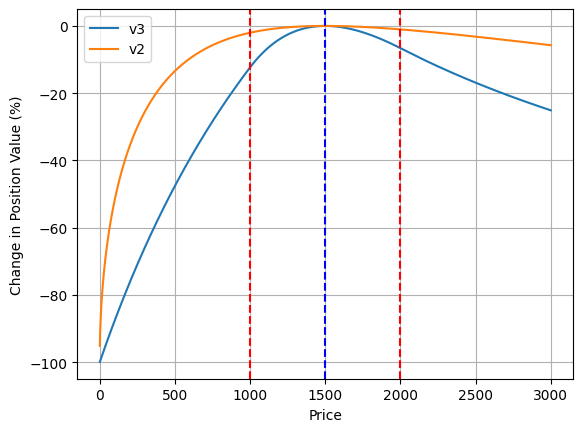

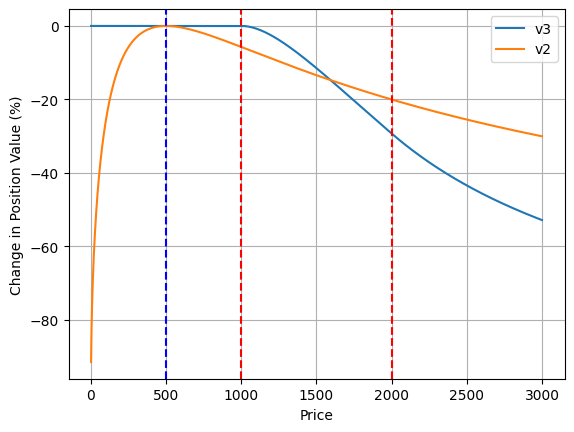

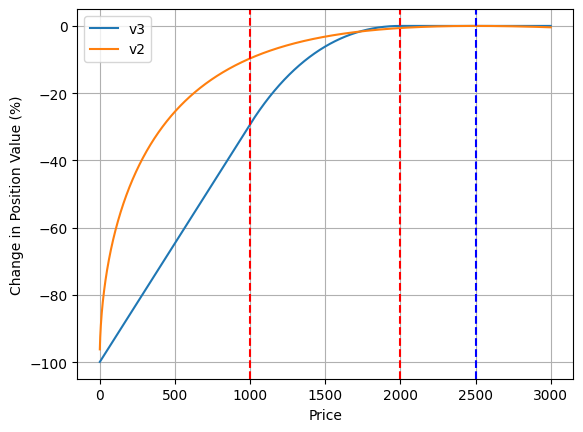

In [9]:
"""
    Consider the following UniswapV3 ETH/USDC position:

    V_0 = 10000
    p_a, p_b = 1000, 2000

    Case 1: p_0 = 1500 (p_a <= p_0 <= p_b)
    Case 2: p_0 = 500 (p_0 <= p_a)
    Case 3: p_0 = 2500 (p_0 >= p_b)
"""

def plot_uniswap_v3_impernanent_loss_to_v2(p_a: float, p_b: float, p_0: float, position_value: float=10000):
    L = get_liquidity_parameter(p_a, p_b, p_0, position_value)
    IL = np.vectorize(partial(get_fraction_of_impernanent_loss, L, p_a, p_b, p_0))
    IL_v2 = np.vectorize(partial(get_fraction_of_impernanent_loss, L, 0.01, 1e9, p_0))
    
    prices = np.linspace(1, 3000, 10000)
    il = IL(prices) * 100
    il_v2 = IL_v2(prices) * 100
    
    plt.plot(prices, il, label='v3')
    plt.plot(prices, il_v2, label='v2')
    plt.axvline(x=p_a, color='r', linestyle='--')
    plt.axvline(x=p_b, color='r', linestyle='--')
    plt.axvline(x=p_0, color='b', linestyle='--')
    plt.xlabel('Price')
    plt.ylabel('Change in Position Value (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

p_a, p_b = 1000, 2000
plot_uniswap_v3_impernanent_loss_to_v2(p_a=p_a, p_b=p_b, p_0=1500)
plot_uniswap_v3_impernanent_loss_to_v2(p_a=p_a, p_b=p_b, p_0=500)
plot_uniswap_v3_impernanent_loss_to_v2(p_a=p_a, p_b=p_b, p_0=2500)

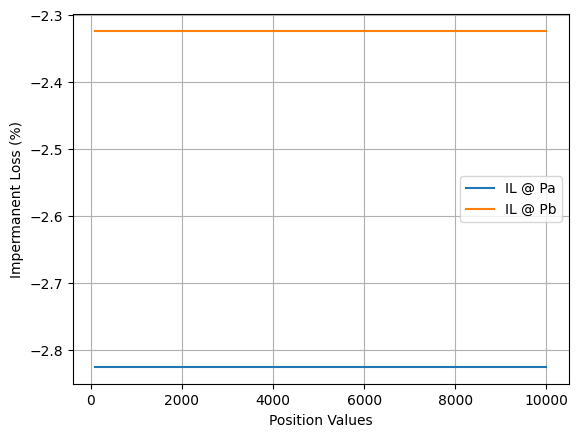

In [10]:
"""
    Consider the following UniswapV3 ETH/USDC position:
    
    p_a <= p_0 <= p_b
    100 <= V <= 1000

    Conclusion: Impermanent Loss is independent of initial position value
"""


def fn(p_a, p_b, p_0, p, position_value):
    L = get_liquidity_parameter(p_a, p_b, p_0, position_value)
    il = get_fraction_of_impernanent_loss(L, p_a, p_b, p_0, p)
    return round(il, 6)

p_0 = 2450
p_a = p_0 * 0.9 # -10%
p_b = p_0 * 1.1 # +10%

IL_p_a_fn = np.vectorize(partial(fn, p_a, p_b, p_0, p_a))
IL_p_b_fn = np.vectorize(partial(fn, p_a, p_b, p_0, p_b))

position_values = np.linspace(100, 10000, 1000)
il_pa = IL_p_a_fn(position_values) * 100
il_pb = IL_p_b_fn(position_values) * 100

plt.plot(position_values, il_pa, label='IL @ Pa')
plt.plot(position_values, il_pb, label='IL @ Pb')
plt.xlabel('Position Values')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()

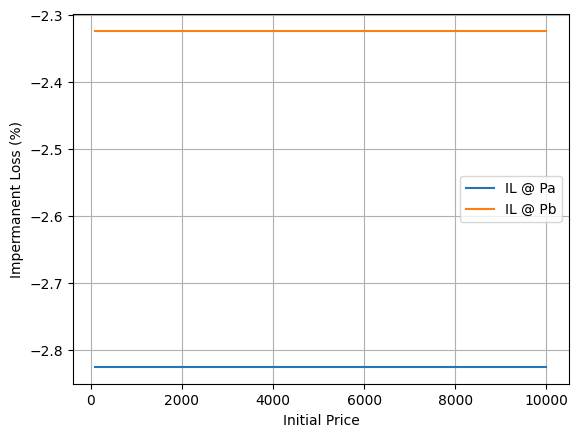

In [11]:
"""
    Consider the following UniswapV3 ETH/USDC position:

    p_a = p_0 * 0.9
    p_b = p_0 * 1.1
    p_a <= p_0 <= p_b
    V = 1000

    Conclusion: Impermanent Loss is independent of initial price
"""


def fn(position_value, is_pa, p_0):
    p_a = p_0 * 0.9
    p_b = p_0 * 1.1
    p = p_a if is_pa else p_b
    L = get_liquidity_parameter(p_a, p_b, p_0, position_value)
    il = get_fraction_of_impernanent_loss(L, p_a, p_b, p_0, p)
    return round(il, 6)

position_value = 1000

IL_p_a_fn = np.vectorize(partial(fn, position_value, True))
IL_p_b_fn = np.vectorize(partial(fn, position_value, False))

p_0_values = np.linspace(100, 10000, 1000)
il_pa = IL_p_a_fn(p_0_values) * 100
il_pb = IL_p_b_fn(p_0_values) * 100

plt.plot(p_0_values, il_pa, label='IL @ Pa')
plt.plot(p_0_values, il_pb, label='IL @ Pb')
plt.xlabel('Initial Price')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()

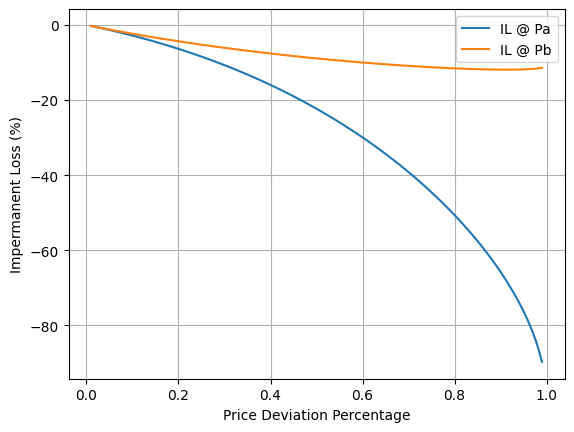

In [12]:
"""
    Consider the following UniswapV3 ETH/USDC position:

    V = 1000
    p_0 = 1500
    p_a <= p_0 <= p_b
    
    p_a = p_0 * (1 - d)
    p_b = p_0 * (1 + d)

    0 < d < 1

    Conclusion: IL dependent on price deviation of range from initial price
"""

def fn(position_value, p_0, is_pa, d):
    p_a = p_0 * (1 - d)
    p_b = p_0 * (1 + d)
    p = p_a if is_pa else p_b
    L = get_liquidity_parameter(p_a, p_b, p_0, position_value)
    il = get_fraction_of_impernanent_loss(L, p_a, p_b, p_0, p)
    return round(il, 6)

p_0 = 1500
position_value = 1000

IL_p_a_fn = np.vectorize(partial(fn, position_value, p_0, True))
IL_p_b_fn = np.vectorize(partial(fn, position_value, p_0, False))

d_values = np.linspace(0.01, 0.99, 100)
il_pa = IL_p_a_fn(d_values) * 100
il_pb = IL_p_b_fn(d_values) * 100

plt.plot(d_values, il_pa, label='IL @ Pa')
plt.plot(d_values, il_pb, label='IL @ Pb')
plt.xlabel('Price Deviation Percentage')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()

Fitted equation: y = 1.555 * exp(-20.551 * x)


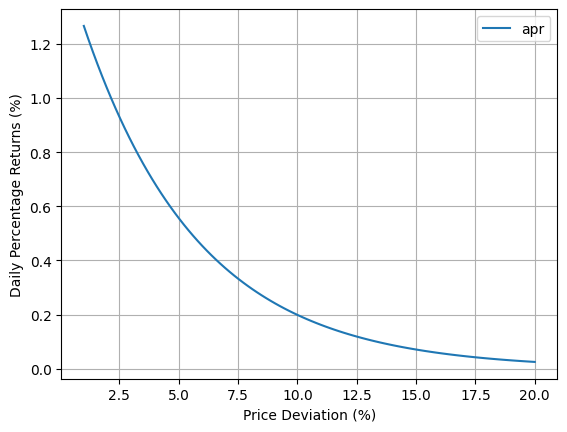

In [13]:
# import numpy as np
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt
# x_data = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2])
# y_data = np.array([2.63, 1.703, 1.261, 0.993, 0.819, 0.673, 0.599, 0.528, 0.471, 0.438, 0.396, 0.368, 0.338, 0.317, 0.298, 0.275, 0.258, 0.249, 0.232, 0.223])
# def exponential_func(x, a, b):
#    return a * np.exp(b * x)
# params, covariance = curve_fit(exponential_func, x_data, y_data)
# a_fit, b_fit = params
# print(f"Fitted equation: y = {a_fit:.3f} * exp({b_fit:.3f} * x)")

def fn(x):
    # return 2.752 * math.exp(-20.551 * x)
    return 1.555 * math.exp(-20.551 * x)

f = np.vectorize(fn)
x = np.linspace(0.01, 0.2, 100)
y = f(x)

print(f"Fitted equation: y = 1.555 * exp(-20.551 * x)")

plt.plot(x * 100, y, label='apr')
plt.xlabel('Price Deviation (%)')
plt.ylabel('Daily Percentage Returns (%)')
plt.grid(True)
plt.legend()
plt.show()


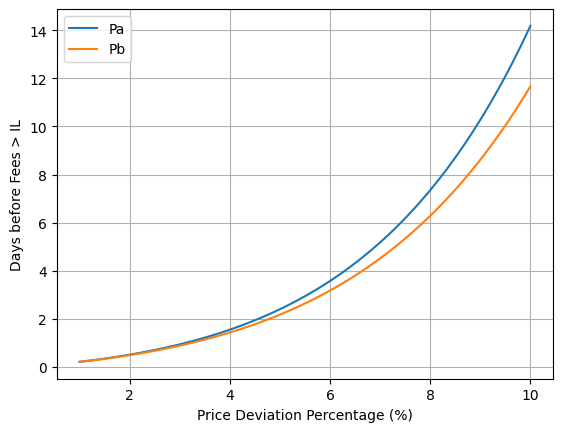

In [14]:
def get_daily_percentage_returns(d):
    return 1.555 * math.exp(-20.551 * d)

def fn(position_value, p_0, is_pa, d):
    p_a = p_0 * (1 - d)
    p_b = p_0 * (1 + d)
    p = p_a if is_pa else p_b
    L = get_liquidity_parameter(p_a, p_b, p_0, position_value)
    il = get_fraction_of_impernanent_loss(L, p_a, p_b, p_0, p)
    daily_percentage_returns = get_daily_percentage_returns(d)
    days = abs(il) / daily_percentage_returns
    return round(days, 6)

p_0 = 1500
position_value = 1000

days_p_a_fn = np.vectorize(partial(fn, position_value, p_0, True))
days_p_b_fn = np.vectorize(partial(fn, position_value, p_0, False))

d_values = np.linspace(0.01, 0.1, 100)
days_pa = days_p_a_fn(d_values) * 100
days_pb = days_p_b_fn(d_values) * 100

plt.plot(d_values * 100, days_pa, label='Pa')
plt.plot(d_values * 100, days_pb, label='Pb')
plt.xlabel('Price Deviation Percentage (%)')
plt.ylabel('Days before Fees > IL')
plt.grid(True)
plt.legend()
plt.show()